In [1]:
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from scipy.spatial import Voronoi
import numpy as np
from shapely.geometry import shape, mapping
from shapely import geometry
import geojson

In [2]:
class Centerline(object):
    def __init__(self, inputGEOM, dist=0.5):
        self.inputGEOM = inputGEOM
        self.dist = abs(dist)

    def create_centerline(self):
        """
        Calculates the centerline of a polygon.

        Densifies the border of a polygon which is then represented
        by a Numpy array of points necessary for creating the
        Voronoi diagram. Once the diagram is created, the ridges
        located within the polygon are joined and returned.

        Returns:
            a MultiLinestring located within the polygon.
        """

        minx = int(min(self.inputGEOM.envelope.exterior.xy[0]))
        miny = int(min(self.inputGEOM.envelope.exterior.xy[1]))

        border = np.array(self.densify_border(self.inputGEOM, minx, miny))

        vor = Voronoi(border)
        vertex = vor.vertices

        lst_lines = []
        for j, ridge in enumerate(vor.ridge_vertices):
            if -1 not in ridge:
                line = LineString([
                    (vertex[ridge[0]][0] + minx, vertex[ridge[0]][1] + miny),
                    (vertex[ridge[1]][0] + minx, vertex[ridge[1]][1] + miny)])

                if line.within(self.inputGEOM) and len(line.coords[0]) > 1:
                    lst_lines.append(line)

        return MultiLineString(lst_lines)

    def densify_border(self, polygon, minx, miny):
        """
        Densifies the border of a polygon by a given factor
        (by default: 0.5).

        The function tests the complexity of the polygons
        geometry, i.e. does the polygon have holes or not.
        If the polygon doesn't have any holes, its exterior
        is extracted and densified by a given factor. If the
        polygon has holes, the boundary of each hole as
        well as its exterior is extracted and densified
        by a given factor.

        Returns:
            a list of points where each point is represented
            by a list of its
            reduced coordinates.

        Example:
            [[X1, Y1], [X2, Y2], ..., [Xn, Yn]
        """

        if len(polygon.interiors) == 0:
            exterior_line = LineString(polygon.exterior)
            points = self.fixed_interpolation(exterior_line, minx, miny)

        else:
            exterior_line = LineString(polygon.exterior)
            points = self.fixed_interpolation(exterior_line, minx, miny)

            for j in range(len(polygon.interiors)):
                interior_line = LineString(polygon.interiors[j])
                points += self.fixed_interpolation(interior_line, minx, miny)

        return points

    def fixed_interpolation(self, line, minx, miny):
        """
        A helping function which is used in densifying
        the border of a polygon.

        It places points on the border at the specified distance.
        By default the distance is 0.5 (meters) which means
        that the first point will be placed 0.5 m from the
        starting point, the second point will be placed at the
        distance of 1.0 m from the first point, etc. Naturally,
        the loop breaks when the summarized distance exceeds
        the length of the line.

        Returns:
            a list of points where each point is represented by
            a list of its reduced coordinates.

        Example:
            [[X1, Y1], [X2, Y2], ..., [Xn, Yn]
        """

        count = self.dist
        newline = []

        startpoint = [line.xy[0][0] - minx, line.xy[1][0] - miny]
        endpoint = [line.xy[0][-1] - minx, line.xy[1][-1] - miny]
        newline.append(startpoint)

        while count < line.length:
            point = line.interpolate(count)
            newline.append([point.x - minx, point.y - miny])
            count += self.dist

        newline.append(endpoint)

        return newline

In [3]:
geojson_path = r"D:\jupyter notebooks\3427.10 Myanmar FewsPi\GEE training\Training december 2018\envelope_river_irrawady.geojson"
with open(geojson_path, 'r') as fp:
    gj = geojson.load(fp)

In [4]:
river_enveloppe = shape(gj['features'][0]['geometry'])

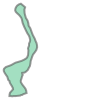

In [5]:
river_enveloppe

In [6]:
# # use voronoi to create centerline
# center_obj = Centerline(river_enveloppe, 0.046)
# center_line = center_obj.create_centerline()
# center_line

In [7]:
geojson_cl_path = r"D:\jupyter notebooks\3427.10 Myanmar FewsPi\GEE training\Training december 2018\riverline_envelope_irrawady.geojson"
with open(geojson_cl_path, 'r') as fp:
    gj_cl = geojson.load(fp)

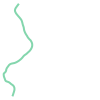

In [8]:
center_line = shape(gj_cl['features'][0]['geometry'])
#center_line = list(center_line)[0]
#center_line.coords = list(center_line.coords)[::-1]
center_line

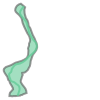

In [9]:
geometry.GeometryCollection([river_enveloppe, center_line])

In [10]:
# distance between each points
distance = 0.01

In [11]:
list_points = []
list_dist = []

# set the current distance to place the point
current_dist = distance

# get the total length of the line
line_length = center_line.length

## append the starting coordinate to the list
list_points.append(geometry.Point(list(center_line.coords)[0]))


# while the current cumulative distance is less than the total length of the line
while current_dist < line_length:
    ## use interpolate and increase the current distance
    list_points.append(center_line.interpolate(current_dist))
    list_dist.append(current_dist)
    current_dist += distance

list_dist.append(current_dist)
# append end coordinate to the list
list_points.append(geometry.Point(list(center_line.coords)[-1]))

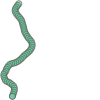

In [12]:
perp_points = geometry.MultiPoint(list_points)
perp_points

In [13]:
line_length

0.5710384196015623

In [14]:
import math
## angle between two points
def getAngle(pt1, pt2):
    x_diff = pt2.x - pt1.x
    y_diff = pt2.y - pt1.y
    return math.degrees(math.atan2(y_diff, x_diff))

# start and end points of chainage tick
# get the first end point of a tick
def getPoint1(pt, bearing, dist):
    angle = bearing + 90
    bearing = math.radians(angle)
    x = pt.x + dist * math.cos(bearing)
    y = pt.y + dist * math.sin(bearing)
    return geometry.Point(x, y)

# get the second end point of a tick
def getPoint2(pt, bearing, dist):
    bearing = math.radians(bearing)
    x = pt.x + dist * math.cos(bearing)
    y = pt.y + dist * math.sin(bearing)
    return geometry.Point(x, y)

In [15]:
# the length of each tick
tick_length = 0.135

In [16]:
list_ticks = []
for idx in range(len(list_points)-1):
    pt = list_points[idx]    
    angle = getAngle(pt, list_points[idx+1])
    line_end_1 = getPoint1(pt, angle, tick_length/2)
    angle = getAngle(line_end_1, pt)
    line_end_2 = getPoint2(line_end_1, angle, tick_length)
    tick = LineString([(line_end_1.x, line_end_1.y), (line_end_2.x, line_end_2.y)]) 
    
    list_ticks.append(tick)

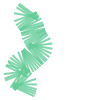

In [17]:
perp_lines = geometry.MultiLineString(list_ticks)
perp_lines

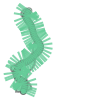

In [18]:
geometry.GeometryCollection([river_enveloppe, 
                             center_line,
                             perp_points,
                             perp_lines
                            ])

In [19]:
# sectinos to geojson

In [20]:
list_features = []
for idx, perp_line in enumerate(perp_lines):
    feat = geojson.Feature(id=idx, geometry=perp_line, properties={"dist":list_dist[idx], "id":idx})
    list_features.append(feat)

In [21]:
feat_col = geojson.FeatureCollection(list_features)

In [22]:
geojson_out_path = r"D:\jupyter notebooks\3427.10 Myanmar FewsPi\GEE training\Training december 2018\sections_river_irrawady2.geojson"
with open(geojson_out_path, 'w') as f:
    geojson.dump(feat_col, f)

In [23]:
# points to geojson

In [24]:
list_features = []
for idx, perp_point in enumerate(perp_points[:-1]):
    feat = geojson.Feature(id=idx, geometry=perp_point, properties={"dist":list_dist[idx], "id":idx})
    list_features.append(feat)

feat_col = geojson.FeatureCollection(list_features)

geojson_out_path = r"D:\jupyter notebooks\3427.10 Myanmar FewsPi\GEE training\Training december 2018\points_river_irrawady2.geojson"
with open(geojson_out_path, 'w') as f:
    geojson.dump(feat_col, f)

In [25]:
# centerline to geojson

In [26]:
feat = geojson.Feature(id=0, geometry=center_line, properties={"id":0})
feat_col = geojson.FeatureCollection([feat])

geojson_out_path = r"D:\jupyter notebooks\3427.10 Myanmar FewsPi\GEE training\Training december 2018\riverline_river_irrawady2.geojson"
with open(geojson_out_path, 'w') as f:
    geojson.dump(feat_col, f)

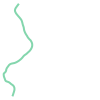

In [27]:
center_line